# Nifty 50 Partial Replication

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


In [2]:
def tracking_error(index, predictions):
    return np.std(pd.Series(index).pct_change()*100 - pd.Series(predictions).pct_change()*100)

## Data

In [3]:
# directory_path = '/kaggle/input/stock-market-data-nifty-50-stocks-1-min-data'
# pattern = os.path.join(directory_path, "*.csv")  # Change "*.csv" to match other patterns if needed

# Get the list of files that match the pattern
# file_list = glob.glob(pattern)

In [4]:
def fetch_data(cols):
    df_list = []
    for file in tqdm(file_list):
        stock_name = os.path.basename(file).split("_")[0]
        file_df = pd.read_csv(file, index_col=0)
        file_df = file_df[[cols]]
        file_df.columns = pd.MultiIndex.from_product([[stock_name], file_df.columns])
        df_list.append(file_df)
    return pd.concat(df_list, axis=1)

In [5]:
# df = fetch_data('close')
# df.to_csv('/kaggle/input/nifty_50_closing.csv')

In [6]:
df = pd.read_csv('/kaggle/input/nifty-50-closing-data/nifty_50_closing.csv', index_col=0, header=[0, 1])
df = df.xs('close', level=1, axis=1)
df.index = pd.to_datetime(df.index)

In [7]:
nifty_100_closing = pd.read_csv('/kaggle/input/nifty-50-minute-data/NIFTY 100_minute.csv', index_col=0)[['close']]
nifty_100_closing.index = pd.to_datetime(nifty_100_closing.index)
nifty_100_closing.rename(columns={'close': 'NIFTY_100'}, inplace=True)

In [8]:
print(f"Index type for df1: {type(df.index)}")
print(f"Index type for df2: {type(nifty_100_closing.index)}")

Index type for df1: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type for df2: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [9]:
# df.interpolate(method='linear', inplace=True)
# To fill the first row NaN with the value from the next minute
df.fillna(0, inplace=True)
df.index = df.index.tz_localize(None)
df.head(3)

,HDFCAMC,APOLLOHOSP,BOSCHLTD,INDUSTOWER,BERGEPAINT,MARICO,ICICIPRULI,HDFCLIFE,SBIN,SUNPHARMA,...,SBICARD,DABUR,SAIL,BRITANNIA,ADANIPORTS,ONGC,EICHERMOT,TECHM,JINDALSTEL,HEROMOTOCO
date,,,,,,,,,,,,,,,,,,,,,
2018-08-06 10:47:00,1803.95,974.3,19187.45,290.0,316.85,357.95,408.50,485.00,306.70,579.65,...,0.0,435.30,79.35,3194.92,400.70,167.75,2711.3,670.45,207.65,3259.0
2018-08-06 10:48:00,1803.90,973.7,19187.45,290.0,316.50,357.55,408.10,484.95,306.70,579.30,...,0.0,435.15,79.30,3193.02,400.55,167.55,2710.6,670.55,207.80,3260.6
2018-08-06 10:49:00,1806.00,973.7,19187.45,290.0,316.85,357.20,408.85,485.00,306.75,579.45,...,0.0,435.70,79.30,3192.50,400.30,167.55,2709.8,670.65,207.55,3259.5


In [10]:
df_total = df.join(nifty_100_closing, how='left')

In [11]:
df_total.dropna(inplace=True)

In [12]:
def train_lasso(alpha, X_train, y_train, X_test, y_test):
    lasso = Lasso(alpha=alpha, max_iter=25000)
    lasso.fit(X_train, y_train)
    coef = lasso.coef_
    features = X.columns

    print(f"-------alpha: {alpha}-------")
    print(f"Train Score: {lasso.score(X_train, y_train)}")
    print(f"Test Score: {lasso.score(X_test, y_test)}")
    
    # Create a DataFrame for the coefficients
    coef_df = pd.DataFrame({'Stock': features, 'Coefficient': coef})

    # Filter for non-zero coefficients
    chosen_stocks = coef_df[coef_df['Coefficient'] != 0]['Stock'].values

    predicted = lasso.predict(X_test)

    track_err = tracking_error(predicted, y_test.values)  

    # Get non-zero coefficients
    coef = lasso.coef_
    features = X.columns
    coef_df = pd.DataFrame({'Stock': features, 'Coefficient': coef})    
    chosen_stocks = coef_df[coef_df['Coefficient'] != 0]
    print(f"Number of Stocks Chosen: {len(chosen_stocks)}/50")

    return (chosen_stocks, track_err)

-------alpha: 0.05-------
Train Score: 0.9972385369554938
Test Score: 0.9970756659244588
Number of Stocks Chosen: 99/50
-------alpha: 0.1-------
Train Score: 0.9972385301722438
Test Score: 0.9970756933983768
Number of Stocks Chosen: 99/50
-------alpha: 0.5-------
Train Score: 0.9972384700282269
Test Score: 0.9970759042936485
Number of Stocks Chosen: 99/50
-------alpha: 1-------
Train Score: 0.9972383716754227
Test Score: 0.9970761375209187
Number of Stocks Chosen: 99/50
-------alpha: 10-------
Train Score: 0.9972308401412935
Test Score: 0.9970726347012127
Number of Stocks Chosen: 96/50
-------alpha: 25-------
Train Score: 0.9972042919026053
Test Score: 0.9970493625208339
Number of Stocks Chosen: 93/50
-------alpha: 50-------
Train Score: 0.99713874392058
Test Score: 0.9969890924903365
Number of Stocks Chosen: 91/50


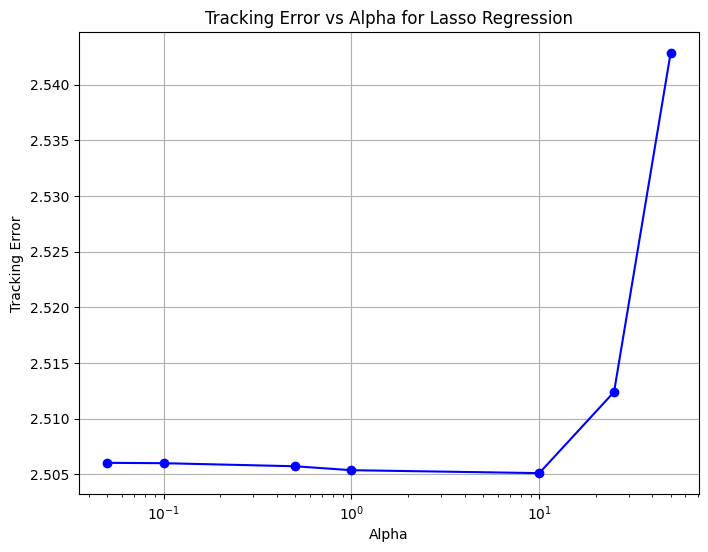

In [13]:
X = df_total.drop(columns=['NIFTY 50', 'NIFTY BANK', 'NIFTY_100'])
y = df_total['NIFTY_100']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


alphas = [0.05, 0.1, 0.5, 1, 10, 25, 50]
tracking_errs = []
chosen_stocks = []
for alpha in alphas:
    (stocks, err) = train_lasso(alpha, X_train, y_train, X_test, y_test)
    tracking_errs.append(err)
    chosen_stocks.append(stocks)

plt.figure(figsize=(8, 6))
plt.plot(alphas, tracking_errs, marker='o', linestyle='-', color='b')
plt.xscale('log')  # Use logarithmic scale for alpha
plt.xlabel('Alpha')
plt.ylabel('Tracking Error')
plt.title('Tracking Error vs Alpha for Lasso Regression')
plt.grid(True)
plt.show()